In [4]:
import torch
import numpy as np
import cv2
# Fixar a semente do Torch para operações específicas
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Importa e plota tensor

In [5]:
#First load libraries and images
import math
import torchvision
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.transforms import transforms, InterpolationMode
import best.singular_point as sp

transform = transforms.Compose([
    transforms.Resize((sp.args.img_size, sp.args.img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    transforms.Resize((sp.args.img_size, sp.args.img_size), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                        download=True, transform=transform2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=sp.args.batch_size,
                                        shuffle=False, num_workers=2)

In [6]:
iterator=iter(trainloader)
img,labels = next(iterator)
print(img.shape,labels.shape)
img = img.to(sp.device)

torch.Size([16, 1, 120, 120]) torch.Size([16])


### CustonNetDetector

In [7]:
import torch

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    print(f"Model loaded from {filepath}")
    

# teste = model.copy()
path_siamese = './data/models/sp_52.pth'
sp.args.num_channels = 1
model = sp.SingularPoints(args=sp.args).to(sp.device)
# load_model(model,path_siamese)

Namespace(exported=False, num_channels=1, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=12, box_size=21, nms_size=5, img_size=120, batch_size=16, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)


/home/wagner/.local/lib/python3.11/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


In [95]:
PS = 31

def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    mask = dist_from_center <= radius
    return mask
 
from torch import nn
class Detector(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()
           self.model = model
        def forward(self, x):
            features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= self.model(x)
            return features_key_summary
        
class Detector2(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()
           self.model = model
        def forward(self, x):
            features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= self.model(x)
            return features_key
        
class Descriptor(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()           
           self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
           self.global_max_pool = nn.AdaptiveMaxPool2d(1)
           self.mask=torch.tensor(create_circular_mask(PS,PS)).to(sp.device)
        def forward(self, x):
            x = x * self.mask[None][None]
            summary_pool = torch.cat([self.global_avg_pool(x).squeeze(), self.global_max_pool(x).squeeze()], dim=1)
            return summary_pool

detec = Detector(model)
detec2 = Detector2(model)
desc = Descriptor(model)

In [96]:
import torch
import kornia
from kornia.feature.scale_space_detector import get_default_detector_config, MultiResolutionDetector

device = sp.device

keynet_default_config = {
    'num_filters': 8,
    'num_levels': 3,
    'kernel_size': 5,
    'Detector_conf': {'nms_size': 15, 'pyramid_levels': 1, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 22.0},
}

class CustomNetDetector(MultiResolutionDetector):
    def __init__(
        self,
        model,
        pretrained: bool = False,
        num_features: int = 60,
        keynet_conf=keynet_default_config,
        ori_module=kornia.feature.LAFOrienter(PS),
        aff_module=None,#kornia.feature.LAFAffineShapeEstimator(PS),
    ):
        super().__init__(model, num_features, keynet_conf['Detector_conf'], ori_module, aff_module)


timg_gray = img.to(device)#timg_gray.to(device)
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = desc#sift
detector = CustomNetDetector(detec).to(device)


cuda:0 torch.Size([16, 1, 120, 120])
Time for computing upper levels:  0.03948783874511719
Time for computing downsampling levels:  0.046996116638183594
map  torch.Size([1, 8, 120, 120]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 60, 8, 31, 31])
descs   torch.Size([1, 60, 16])
Time for computing upper levels:  0.036187171936035156
Time for computing downsampling levels:  0.04646110534667969
map  torch.Size([1, 8, 120, 120]) torch.Size([1, 1, 120, 120])
patches   torch.Size([1, 58, 8, 31, 31])
descs   torch.Size([1, 58, 16])
matches  torch.Size([21, 2])
torch.Size([1, 60, 2, 3]) torch.Size([60, 2, 3]) torch.Size([21, 2]) (21, 1)


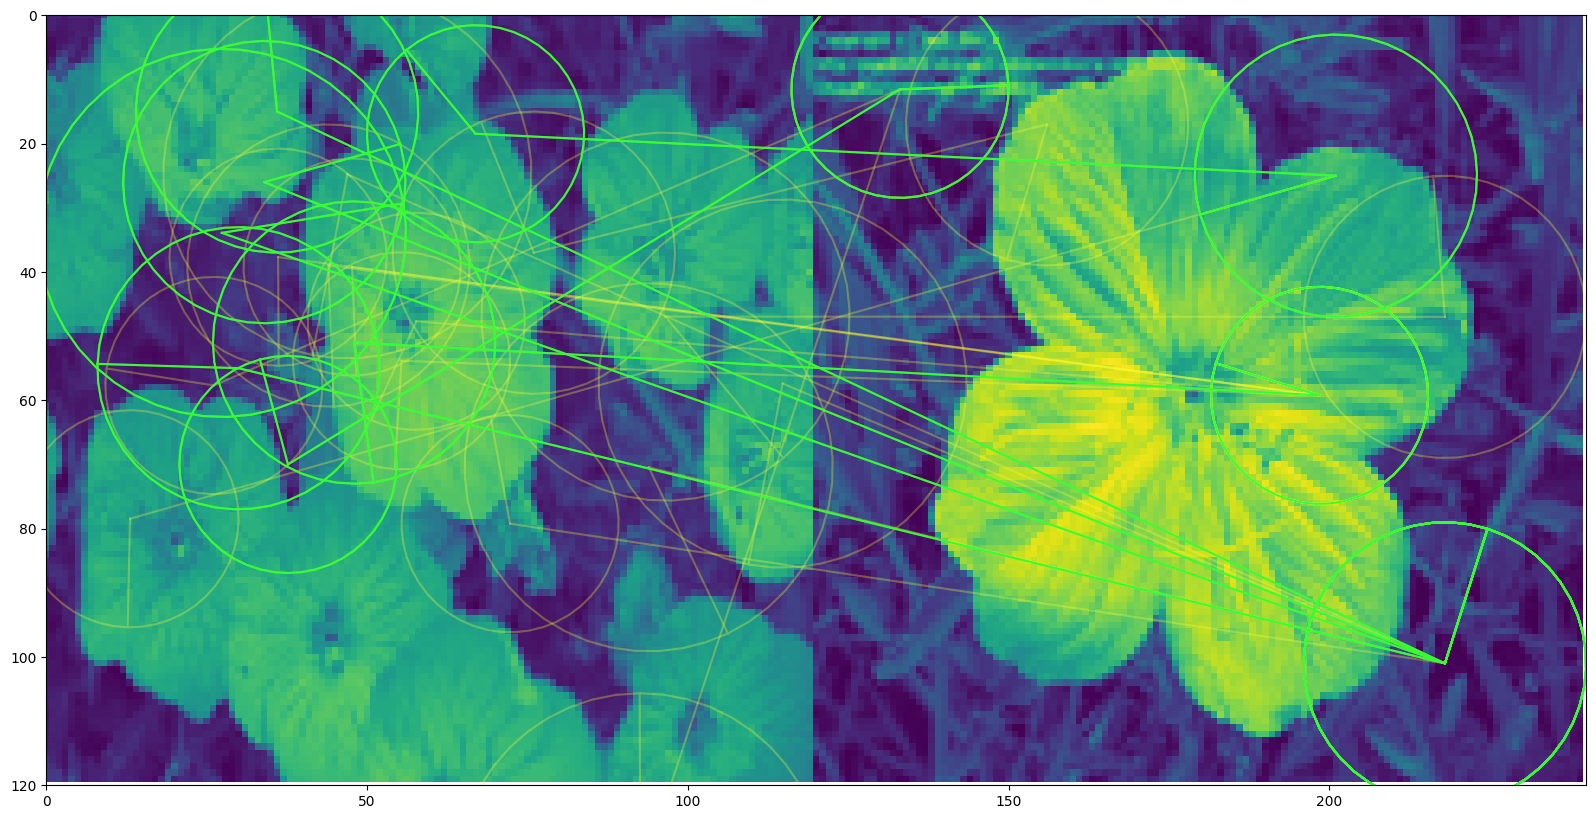

In [97]:
def detect_and_extract_features(image, detector, descriptor, PS):
    with torch.no_grad():
        lafs, resps = detector(image[None])
        map = detec2(image[None])
        print('map ',map.shape,image[None].shape)
        patches = kornia.feature.extract_patches_from_pyramid(map, lafs, PS)
        B, N, CH, H, W = patches.size()
        print('patches  ',patches.shape)
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        print('descs  ',descs.shape)
        return lafs, descs

def compute_homography(lafs1, lafs2, matches):
    src_pts = lafs1[0, matches[:, 0], :, 2].data.cpu().numpy()
    dst_pts = lafs2[0, matches[:, 1], :, 2].data.cpu().numpy()
    F, inliers_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 1000)
    inliers_point = matches[torch.from_numpy(inliers_mask).bool().squeeze(), :]
    return inliers_mask

print(timg_gray.device,timg_gray.shape)
with torch.no_grad():
    lafs1, descs1 = detect_and_extract_features(timg_gray[0],detector,descriptor,PS)
    
    lafs2, descs2 = detect_and_extract_features(timg_gray[1],detector,descriptor,PS)
    
    scores, matches = kornia.feature.match_snn(descs1[0], descs2[0], 0.9)
    
print('matches ',matches.shape)

if(matches.shape[0] < 4):
    print("No matches found")
else:
    # Cálculo da homografia
    inliers_mask = compute_homography(lafs1, lafs2, matches)
    print(lafs1[0][None].shape, lafs1[0].shape, matches.shape, inliers_mask.shape)

    from kornia_moons.viz import draw_LAF_matches

    draw_LAF_matches(
        lafs1[0][None].cpu(),
        lafs2[0][None].cpu(),
        matches.cpu(),
        kornia.tensor_to_image(timg_gray[0].cpu()),
        kornia.tensor_to_image(timg_gray[1].cpu()),
        inliers_mask,
        draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
    )